In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [3]:
train_data_path = join('data', 'train.csv')
sub_data_path = join('data', 'test.csv')
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

In [4]:
data_id = data['id']
del data['id']
sub_id = sub['id']
del sub['id']

In [5]:
train_len = len(data)
y = data['price']
df = pd.concat((data, sub), axis=0, ignore_index=True)
df.isna().sum().sum()

6468

In [6]:
df['date'] = df['date'].apply(lambda x : str(x[:6])).astype(int)
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,NaN,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,201501,NaN,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,201502,NaN,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,201406,NaN,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [7]:
df.loc[df['yr_renovated'] != 0, 'yr_built'] = df['yr_renovated']
del df['yr_renovated']

In [8]:
df['date'] = df['date'] - 201400
df['lat'] = df['lat'].apply(lambda x : str(x)[3:7]).astype(int)
df['long'] = df['long'].apply(lambda x : str(x)[5:]).astype(int)
df['yr_built'] = df['yr_built'] - 1900
df.loc[df['sqft_basement'] != 0, 'sqft_basement'] = 1
df['lat'] = df['lat'] / df['lat'].max()
df['long'] = df['long'] / df['long'].max()
df['yr_built'] = df['yr_built'] / df['yr_built'].max()
df = df.round(2)
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,10,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,0.48,98178,0.66,0.26,1340,5650
1,102,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,0.29,98028,0.95,0.23,2720,8062
2,102,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,0.76,98074,0.79,0.05,1800,7503
3,6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,0.83,98003,0.40,0.33,2238,6819
4,101,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,0.55,98198,0.53,0.32,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,6,NaN,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,0.99,98010,0.40,0.00,1320,11303
21499,101,NaN,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,0.99,98144,0.73,0.29,1400,1230
21500,102,NaN,3,2.50,1310,1294,2.0,0,0,3,8,1180,1,0.94,98116,0.74,0.41,1330,1265
21501,6,NaN,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,0.95,98144,0.76,0.30,1020,2007


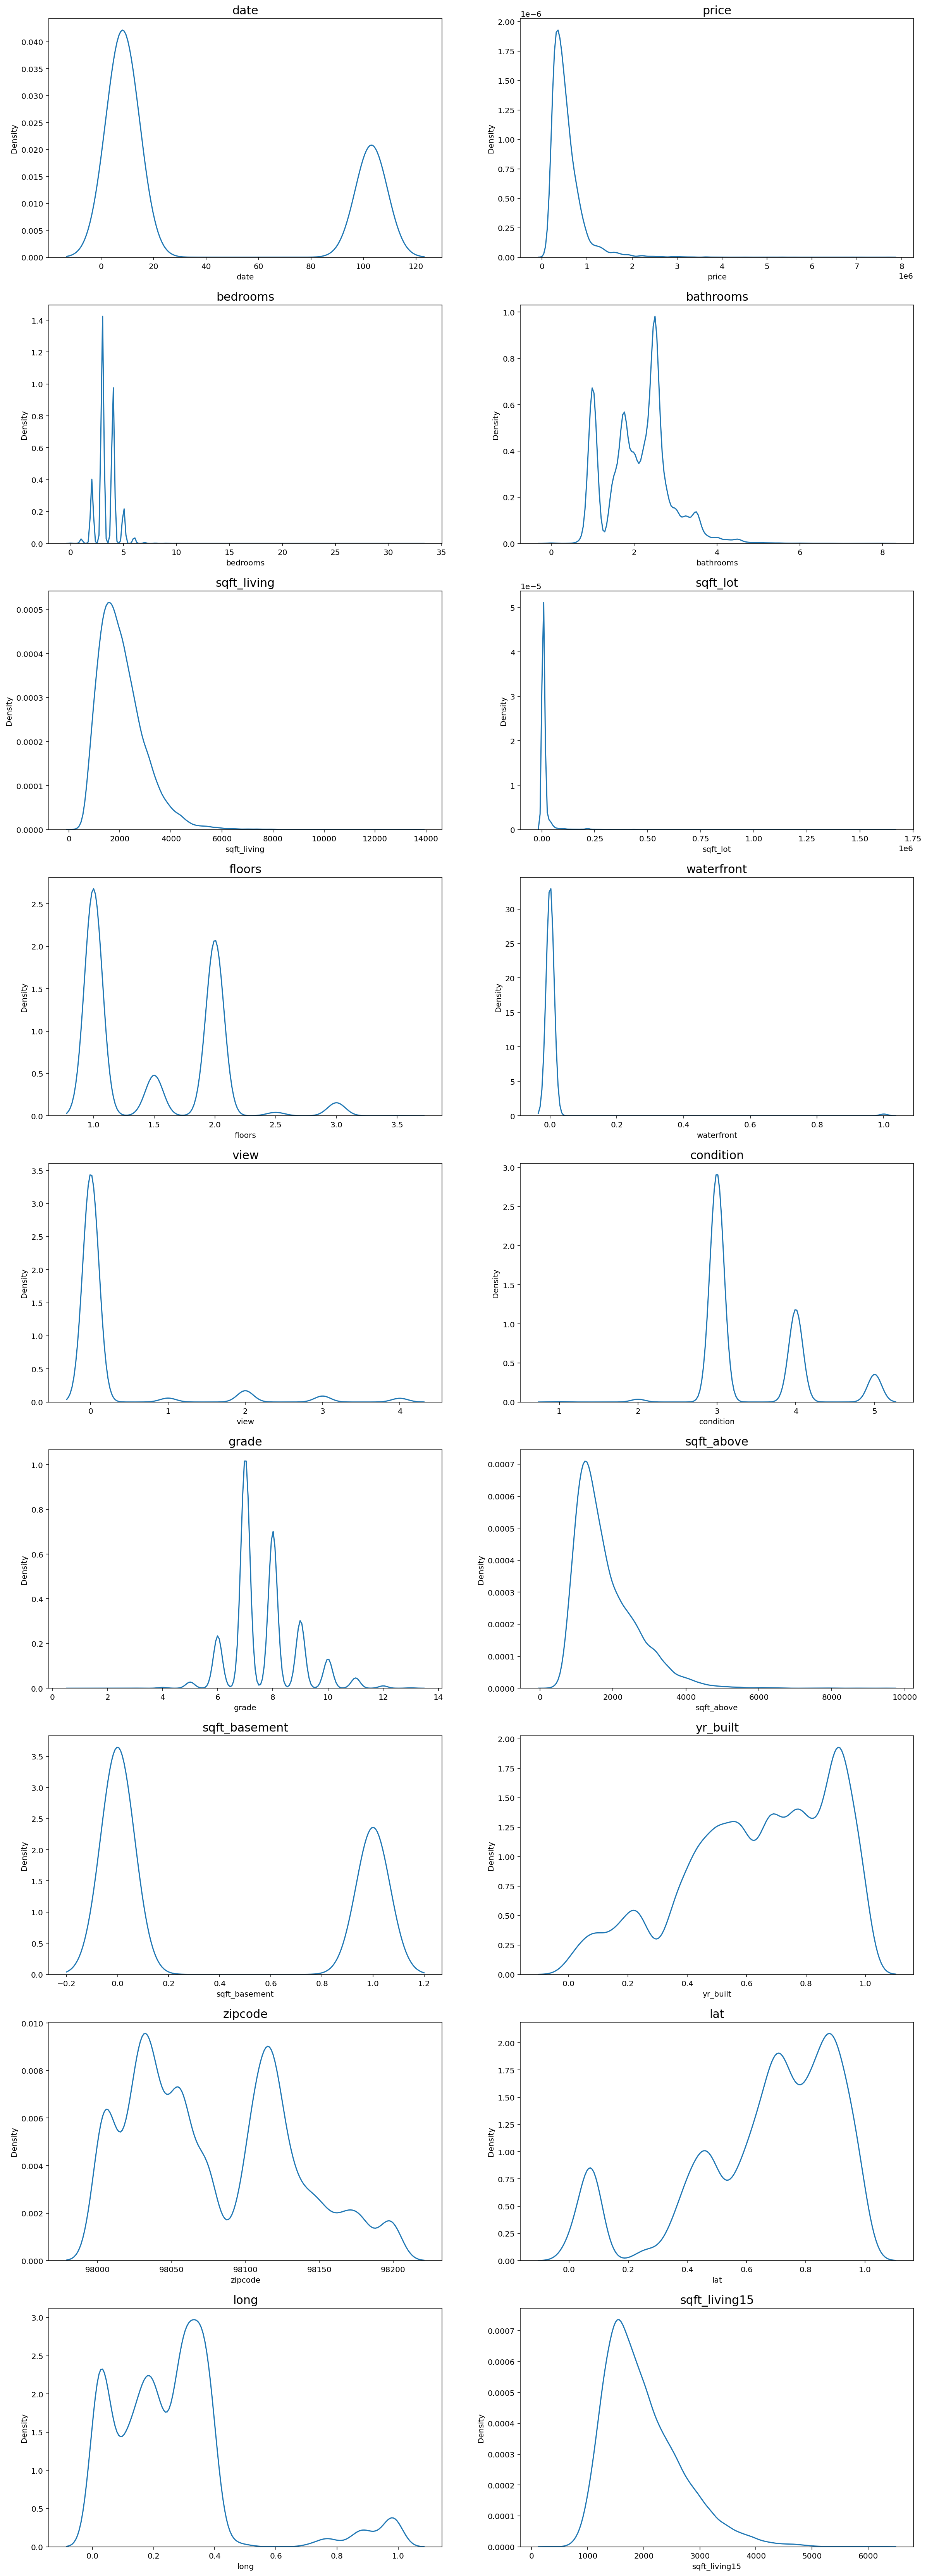

In [9]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = df.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(df[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1

In [10]:
skew_columns = ['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'sqft_above', 'sqft_basement',
               'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    df[c] = np.log1p(df[c].values)

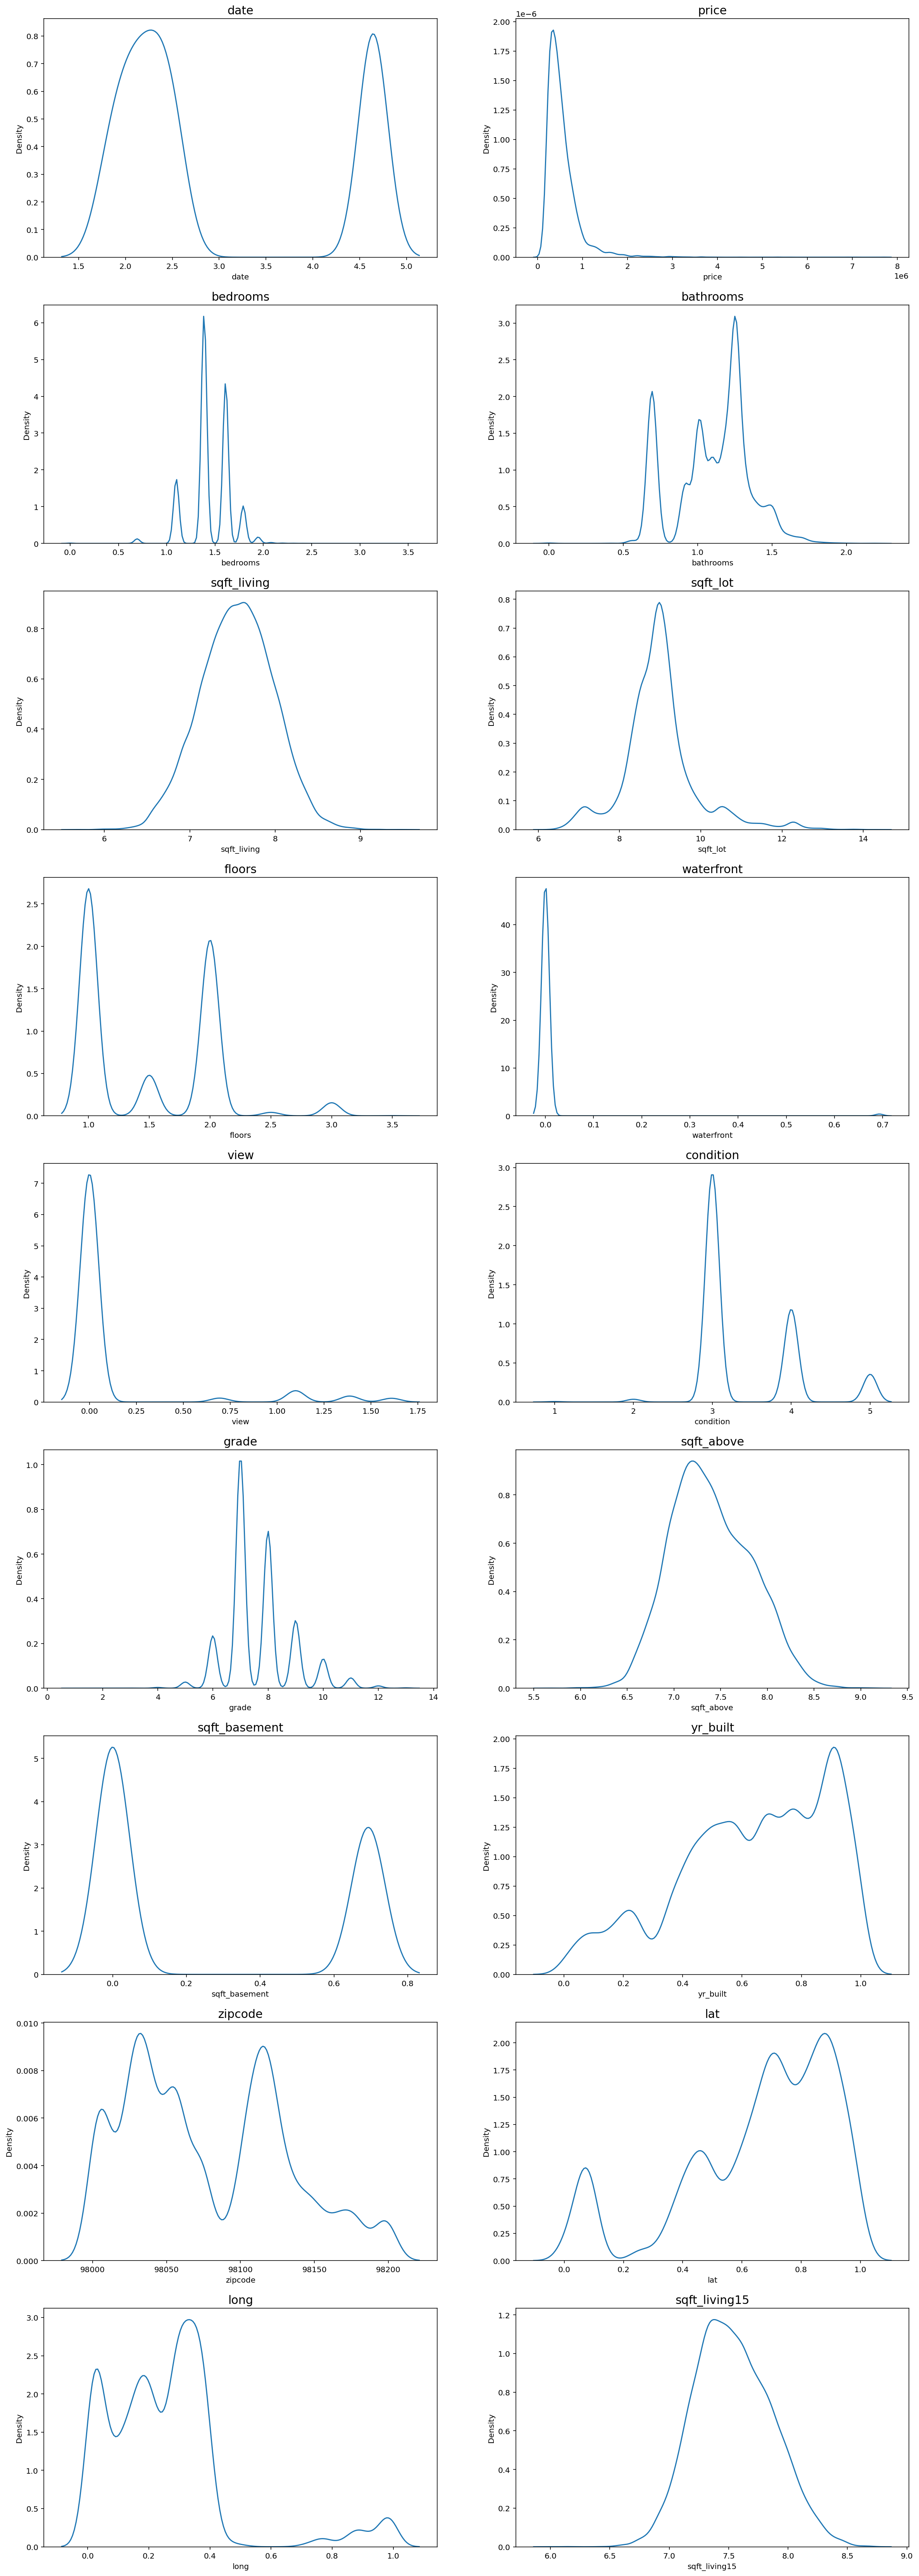

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = df.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(df[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1

In [12]:
cor_abs = abs(df.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=20, columns = 'price').index
cor = np.array(sp.stats.spearmanr(data[cor_cols].values))[0]
cor_cols

Index(['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above',
       'bathrooms', 'lat', 'bedrooms', 'floors', 'view', 'sqft_basement',
       'yr_built', 'waterfront', 'sqft_lot', 'sqft_lot15', 'long', 'condition',
       'zipcode', 'date'],
      dtype='object')

<AxesSubplot:>

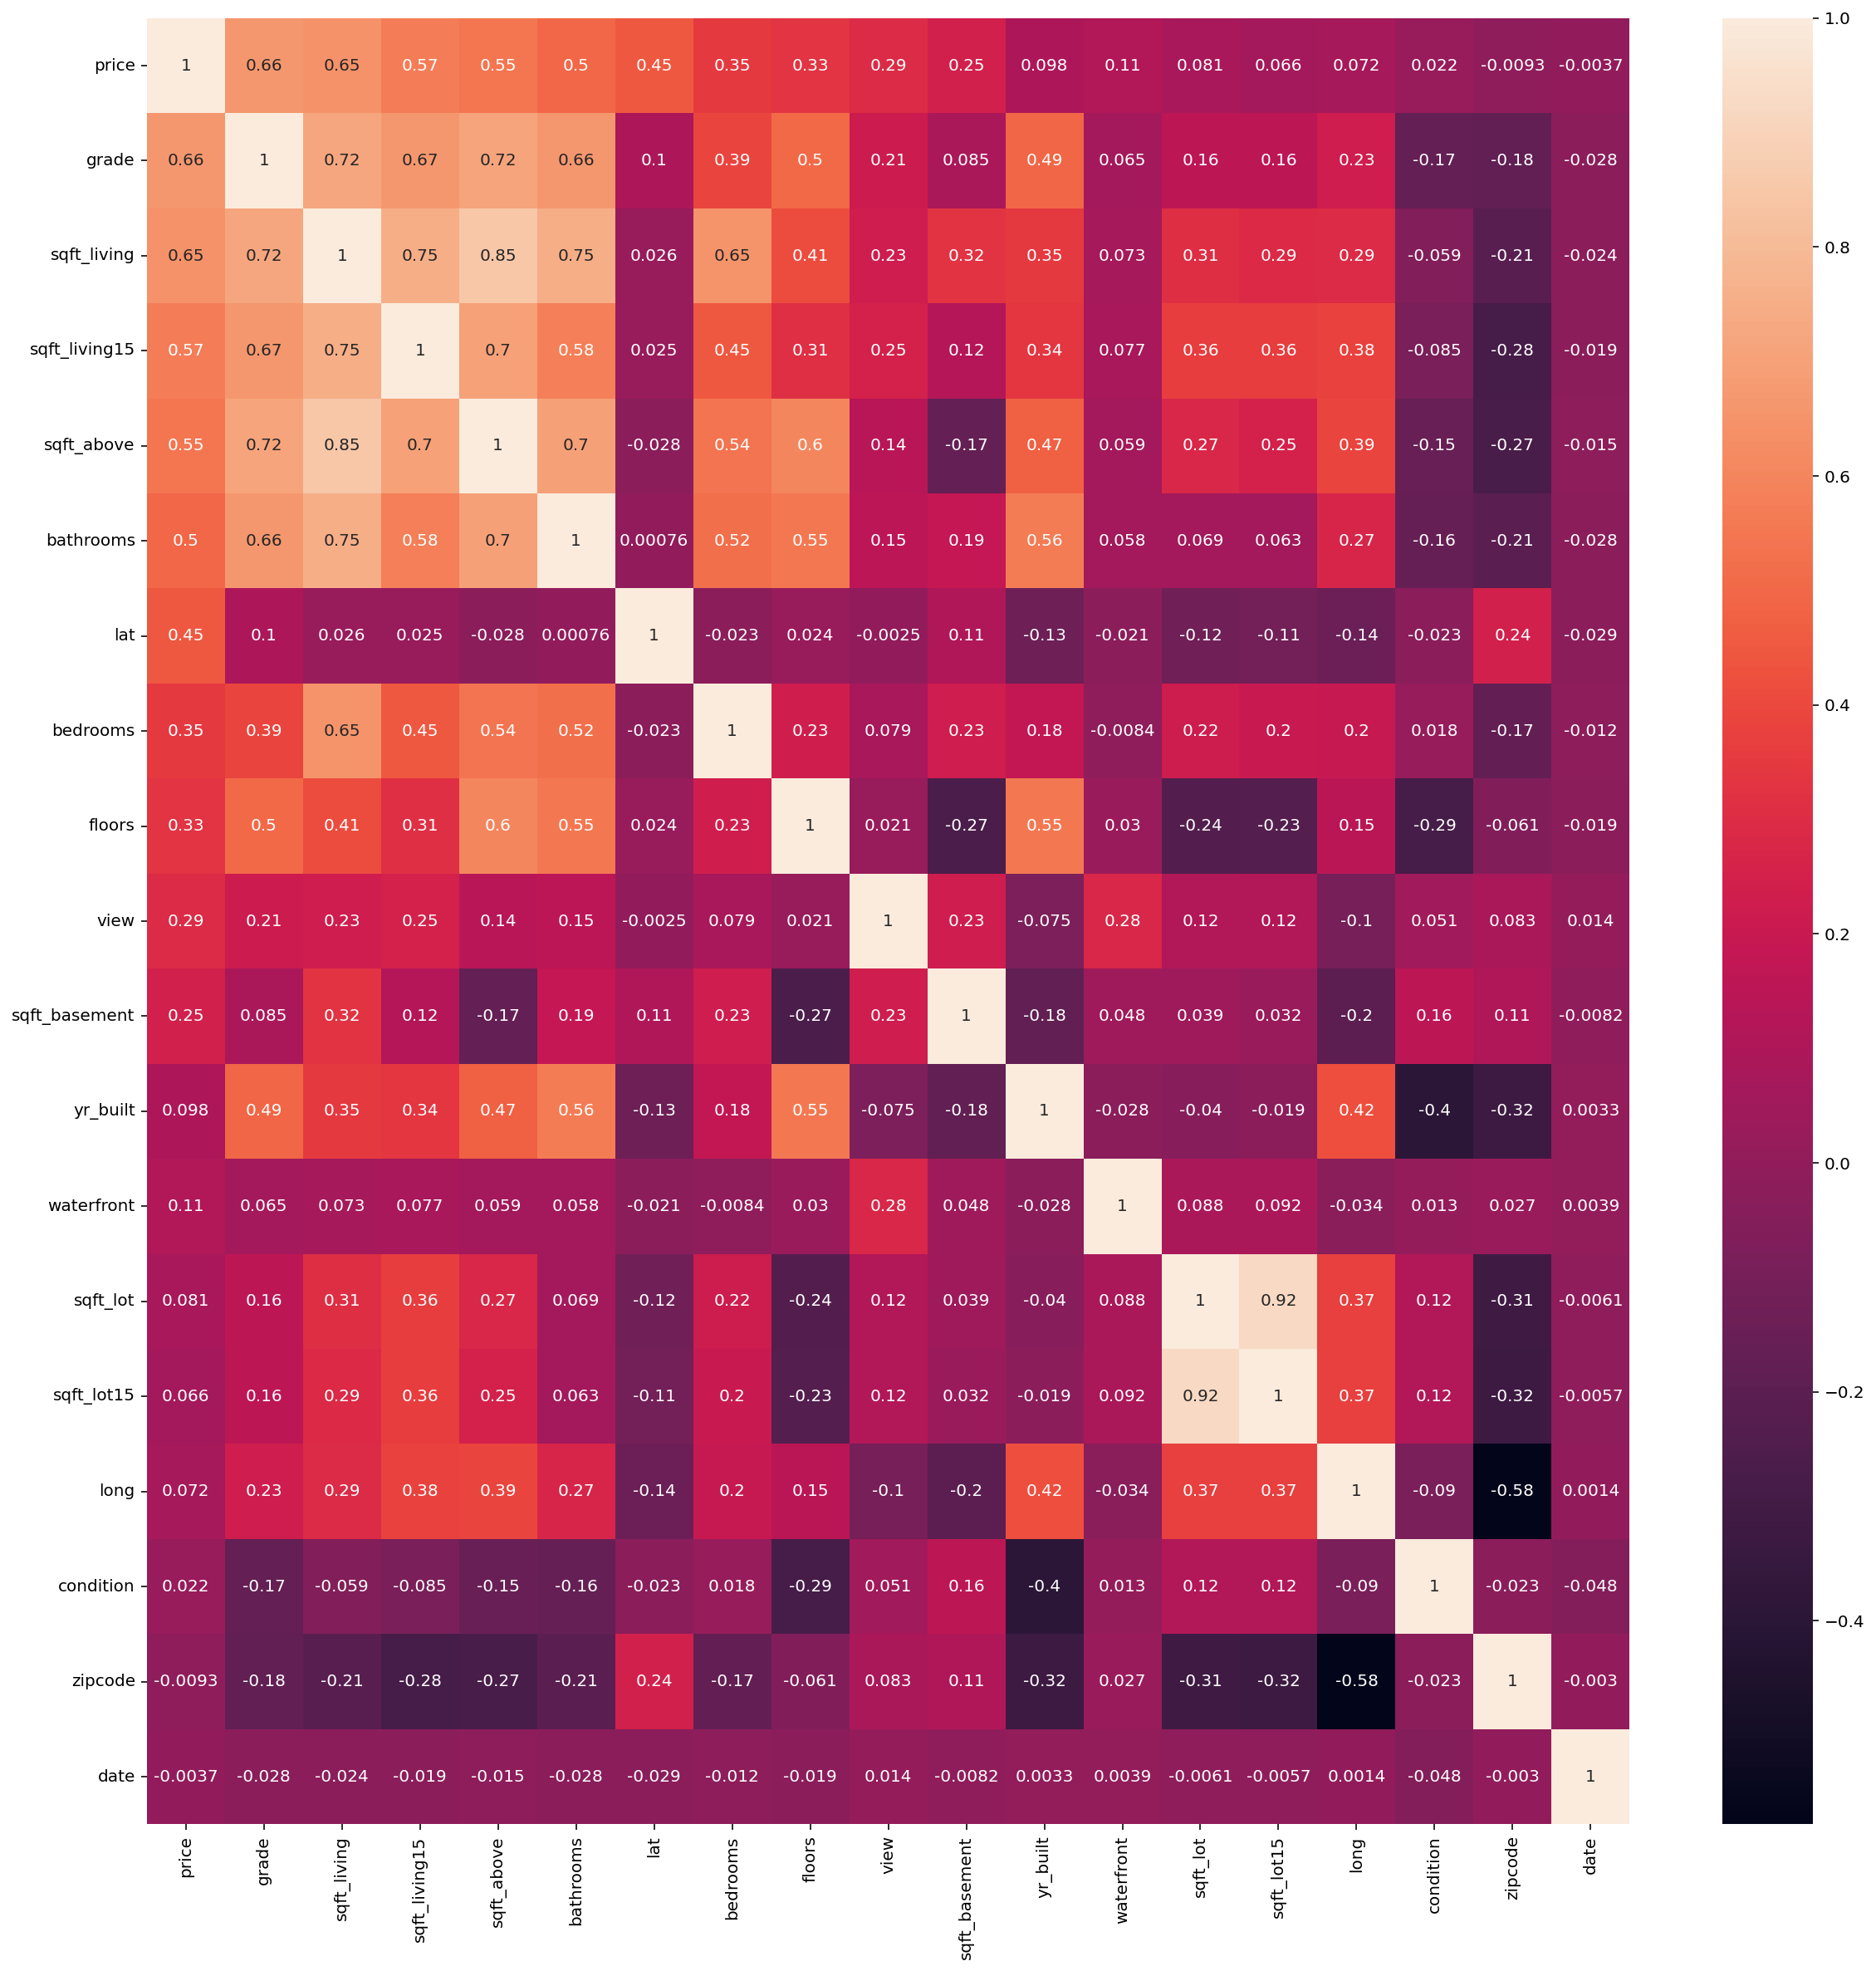

In [13]:
plt.figure(figsize=(20, 20))
sns.heatmap(cor, annot=True, xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [14]:
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,2.397895,221900.0,1.386294,0.693147,7.074117,8.639588,1.0,0.0,0.0,3,7,7.074117,0.000000,0.48,98178,0.66,0.26,7.201171,8.639588
1,4.634729,180000.0,1.098612,0.693147,6.647688,9.210440,1.0,0.0,0.0,3,6,6.647688,0.000000,0.29,98028,0.95,0.23,7.908755,8.995041
2,4.634729,510000.0,1.386294,1.098612,7.427144,8.997271,1.0,0.0,0.0,3,8,7.427144,0.000000,0.76,98074,0.79,0.05,7.496097,8.923191
3,1.945910,257500.0,1.386294,1.178655,7.447751,8.827615,2.0,0.0,0.0,3,7,7.447751,0.000000,0.83,98003,0.40,0.33,7.713785,8.827615
4,4.624973,291850.0,1.386294,0.916291,6.966967,9.181118,1.0,0.0,0.0,3,7,6.966967,0.000000,0.55,98198,0.53,0.32,7.409136,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,1.945910,NaN,1.386294,1.011601,7.313887,9.390075,1.0,0.0,0.0,3,6,7.313887,0.000000,0.99,98010,0.40,0.00,7.186144,9.332912
21499,4.624973,NaN,1.386294,1.098612,7.307202,7.027315,3.0,0.0,0.0,3,8,7.307202,0.000000,0.99,98144,0.73,0.29,7.244942,7.115582
21500,4.634729,NaN,1.386294,1.252763,7.178545,7.166266,2.0,0.0,0.0,3,8,7.074117,0.693147,0.94,98116,0.74,0.41,7.193686,7.143618
21501,1.945910,NaN,1.098612,0.559616,6.928538,7.208600,2.0,0.0,0.0,3,7,6.928538,0.000000,0.95,98144,0.76,0.30,6.928538,7.604894


In [15]:
sub = df.iloc[train_len:, :]
sub =sub.drop(columns='price')
df = df.iloc[:train_len, :]
df = df.drop(columns='price')

In [16]:
random_state = 2023
gboost = GradientBoostingRegressor(random_state=random_state, learning_rate=0.05, max_depth=10, n_estimators= 500)
xgboost = xgb.XGBRegressor(random_state=random_state, learning_rate=0.05, max_depth=10, n_estimators=500)
lightgbm = lgb.LGBMRegressor(random_state=random_state, learning_rate=0.05, max_depth=10, n_estimators=1000)
rdforest = RandomForestRegressor(random_state=random_state, max_depth=10, min_samples_leaf=10, min_samples_split=15, n_estimators=100)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RDForest'}]

In [17]:
def get_cv_score(models, x, y):
    kfold = KFold(n_splits=5).get_n_splits(x)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x, y)), 
                                             kf=kfold))

In [18]:
get_cv_score(models, df.values, y)

Model GradientBoosting CV score : 0.8479
Model XGBoost CV score : 0.8677
Model LightGBM CV score : 0.8728
Model RDForest CV score : 0.8042


In [19]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [20]:
y_pred = AveragingBlending(models[:3], df, y, sub)

In [21]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [22]:
sub.to_csv('submission.csv', index=False)

In [23]:
# from sklearn.model_selection import GridSearchCV


# gboost_param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [5,15,20],
#     'learning_rate':[0.05, 0.1],
# }

# xgboost_param_grid = {
#     'n_estimators': [10, 100],
#     'max_depth': [5,10,15],
#     'min_samples_leaf':[8,10,18],
#     'min_samples_split':[10,15,20],
# }

# lightgbm_param_grid = {
#     'learning_rate':[0.01, 0.05],
#     'n_estimators': [100, 300, 500],
#     'max_depth':[5, 10, 15],
# }
    
# rdforest_param_grid = {
#     'learning_rate':[0.01, 0.05],
#     'max_depth':[5, 10, 15],
#     'n_estimators':[100, 300, 500]
# }

# model = GradientBoostingRegressor(random_state=random_state)
# grid_model = GridSearchCV(model, param_grid=gboost_param_grid, \
#                         scoring='neg_mean_squared_error', \
#                         cv=5, verbose=1, n_jobs=5)

# grid_model.fit(data, y)

In [24]:
# params = grid_model.cv_results_['params']
# score = grid_model.cv_results_['mean_test_score']
# df = pd.DataFrame(params)
# df['score'] = score
# df['RMSE'] = np.sqrt(-1 * df['score'])
# df